In [1]:
import sys
import os
import json
import pandas
import numpy as np
import optparse
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Flatten, SimpleRNN, SpatialDropout1D, ActivityRegularization
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from random import sample
import re
from tensorflow.keras.optimizers import SGD

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords 

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [3]:
# Import dataset
dataframe = pandas.read_csv("data_1w.csv", engine='python')

In [4]:
dataframe.head(5)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1016,1017,1018,1019,1020,1021,1022,1023,Score,Label
0,0,0,0,0,0,0,0,0,0,0,...,191,213,64,343,213,64,3026,753,1,0
1,1,0,0,0,0,0,0,0,0,0,...,316,24,702,18,277,149,363,1674,1,0
2,2,0,0,0,0,0,0,0,0,0,...,696,223,106,532,495,16,1062,2018,1,0
3,3,0,0,0,0,0,0,0,0,0,...,18,59,199,287,298,1,726,484,1,0
4,4,0,0,0,0,0,0,0,0,0,...,3507,128,10,73,507,562,277,149,1,0


In [5]:
dataframe.iloc[:, 1:-2].values

array([[    0,     0,     0, ...,    64,  3026,   753],
       [    0,     0,     0, ...,   149,   363,  1674],
       [    0,     0,     0, ...,    16,  1062,  2018],
       ...,
       [    0,     0,     0, ...,    16,    45,   318],
       [    0,     0,     0, ...,     6,   134, 18865],
       [    0,     0,     0, ...,   782,   418,   514]])

In [6]:
data = dataframe.iloc[:, 1:-2].values
y_label = dataframe['Label'].values
y_score = dataframe['Score'].values
y_score = y_score - 1

In [7]:
# split 80% train and 20% test data
X_train, X_test, y_train, y_test = train_test_split(data, y_label, test_size=0.2, random_state=42)

## Build Model

### Random Forest W Grid Search

In [8]:
# build a base model using Random Forest with Grid Search
param = {'n_estimators': [50, 100, 200, 500], 'max_features': [2, 4, 'sqrt'], 'max_depth': [8, 10, 12, 16], 
         'random_state': [42]}

#scoring = {'accuracy': make_scorer(accuracy_score),
           #'precision': make_scorer(precision_score, average = 'macro'),
           #'recall': make_scorer(recall_score, average = 'macro'),
           #'f1_macro': make_scorer(f1_score, average = 'macro'),
           #'f1_weighted': make_scorer(f1_score, average = 'weighted')}
                                   
rf_model = RandomForestClassifier()
rf_grid = GridSearchCV(rf_model, param, cv = 5, refit = True, scoring='accuracy', n_jobs=-1, verbose=5)

In [9]:
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [8, 10, 12, 16],
                         'max_features': [2, 4, 'sqrt'],
                         'n_estimators': [50, 100, 200, 500],
                         'random_state': [42]},
             scoring='accuracy', verbose=5)

In [10]:
print('Best Parameters: \n', rf_grid.best_params_)

Best Parameters: 
 {'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 500, 'random_state': 42}


In [11]:
best_model = rf_grid.best_estimator_
grid_class = best_model.predict(X_test)

In [12]:
grid_report = classification_report(y_test, grid_class)
print('test_result: \n',grid_report)

test_result: 
               precision    recall  f1-score   support

           0       0.62      0.99      0.76      1012
           1       0.97      0.38      0.55       988

    accuracy                           0.69      2000
   macro avg       0.80      0.68      0.65      2000
weighted avg       0.80      0.69      0.66      2000



In [13]:
grid_train = best_model.predict(X_train)

In [14]:
grid_report_train = classification_report(y_train, grid_train)
print('train_result: \n',grid_report_train)

train_result: 
               precision    recall  f1-score   support

           0       0.64      1.00      0.78      3988
           1       1.00      0.43      0.61      4012

    accuracy                           0.72      8000
   macro avg       0.82      0.72      0.69      8000
weighted avg       0.82      0.72      0.69      8000



In [15]:
rf_model_2 = RandomForestClassifier(max_depth=6, max_features=200, n_estimators=120, random_state=42)
rf_model_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_features=200, n_estimators=120,
                       random_state=42)

In [16]:
rf_class = rf_model_2.predict(X_test)

In [17]:
rf_report = classification_report(y_test, rf_class)
print('test_result: \n',rf_report)

test_result: 
               precision    recall  f1-score   support

           0       0.58      1.00      0.73      1012
           1       1.00      0.25      0.40       988

    accuracy                           0.63      2000
   macro avg       0.79      0.62      0.56      2000
weighted avg       0.79      0.63      0.57      2000



In [18]:
rf_class_train = rf_model_2.predict(X_train)

In [19]:
rf_report_train = classification_report(y_train, rf_class_train)
print('test_result: \n',rf_report_train)

test_result: 
               precision    recall  f1-score   support

           0       0.58      1.00      0.74      3988
           1       1.00      0.29      0.45      4012

    accuracy                           0.64      8000
   macro avg       0.79      0.64      0.59      8000
weighted avg       0.79      0.64      0.59      8000



reduce max_depth, reduce n_estimators, increase max features. Not Overfitting now.

### Gradient Boosting Classifier W GridSearch

In [20]:
param_gradient = {'n_estimators': [50, 100], 
                  'learning_rate': [0.4, 0.8], 
                  'max_depth': [2, 4],
                  'random_state': [42]}

gb_boost = GradientBoostingClassifier()
gb_grid = GridSearchCV(gb_boost, param_gradient, cv = 5, scoring='accuracy', refit='True', n_jobs=-1, verbose=5)

In [21]:
gb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.4, 0.8], 'max_depth': [2, 4],
                         'n_estimators': [50, 100], 'random_state': [42]},
             refit='True', scoring='accuracy', verbose=5)

In [22]:
print('Best Parameters: \n', gb_grid.best_params_)

Best Parameters: 
 {'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 100, 'random_state': 42}


In [23]:
best_gb = gb_grid.best_estimator_
gb_class = best_gb.predict(X_test)

In [24]:
gb_report = classification_report(y_test, gb_class)
print('test_result: \n', gb_report)

test_result: 
               precision    recall  f1-score   support

           0       0.73      0.80      0.76      1012
           1       0.77      0.69      0.73       988

    accuracy                           0.74      2000
   macro avg       0.75      0.74      0.74      2000
weighted avg       0.75      0.74      0.74      2000



In [25]:
gb_train = best_gb.predict(X_train)

In [26]:
gb_report_train = classification_report(y_train, gb_train)
print('test_result: \n', gb_report_train)

test_result: 
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      3988
           1       0.88      0.84      0.86      4012

    accuracy                           0.86      8000
   macro avg       0.86      0.86      0.86      8000
weighted avg       0.86      0.86      0.86      8000



In [27]:
gb_model = GradientBoostingClassifier(learning_rate=0.2, max_depth=2, n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=2, random_state=42)

In [28]:
gb_test = gb_model.predict(X_test)

In [29]:
gb_report_test = classification_report(y_test, gb_test)
print('test_result: \n', gb_report_test)

test_result: 
               precision    recall  f1-score   support

           0       0.67      0.84      0.74      1012
           1       0.78      0.57      0.66       988

    accuracy                           0.71      2000
   macro avg       0.72      0.70      0.70      2000
weighted avg       0.72      0.71      0.70      2000



In [30]:
gb_train_2 = gb_model.predict(X_train)

In [31]:
gb_report_train2 = classification_report(y_train, gb_train_2)
print('train_result: \n', gb_report_train2)

train_result: 
               precision    recall  f1-score   support

           0       0.69      0.86      0.76      3988
           1       0.81      0.61      0.70      4012

    accuracy                           0.73      8000
   macro avg       0.75      0.74      0.73      8000
weighted avg       0.75      0.73      0.73      8000



### LSTM

In [32]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [33]:
#### Base Model

m_1 = Sequential()
m_1.add(Embedding(input_dim = 18866, output_dim = 64, input_length = 2048))
m_1.add(LSTM(units = 64, recurrent_dropout = 0.5))
m_1.add(Dense(units = 1, activation = 'sigmoid'))
m_1.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ['accuracy'])
m_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2048, 64)          1207424   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,240,513
Trainable params: 1,240,513
Non-trainable params: 0
_________________________________________________________________


In [34]:
# split 80% train and 20% test data
X_train, X_test, y_train, y_test = train_test_split(data, y_label, test_size=0.2, random_state=42)

In [35]:
h_1 = m_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)

Epoch 1/10
63/63 [==============================] - 116s 1s/step - loss: 0.6650 - accuracy: 0.6101 - val_loss: 0.4275 - val_accuracy: 0.8140
Epoch 2/10
63/63 [==============================] - 86s 1s/step - loss: 0.3394 - accuracy: 0.8637 - val_loss: 0.3945 - val_accuracy: 0.8235
Epoch 3/10
63/63 [==============================] - 84s 1s/step - loss: 0.2331 - accuracy: 0.9187 - val_loss: 0.4326 - val_accuracy: 0.8250
Epoch 4/10
63/63 [==============================] - 84s 1s/step - loss: 0.1556 - accuracy: 0.9500 - val_loss: 0.5302 - val_accuracy: 0.8195
Epoch 5/10
63/63 [==============================] - 86s 1s/step - loss: 0.1144 - accuracy: 0.9625 - val_loss: 0.6525 - val_accuracy: 0.7995
Epoch 6/10
63/63 [==============================] - 86s 1s/step - loss: 0.0861 - accuracy: 0.9748 - val_loss: 0.6898 - val_accuracy: 0.7995
Epoch 7/10
63/63 [==============================] - 84s 1s/step - loss: 0.0694 - accuracy: 0.9786 - val_loss: 0.6676 - val_accuracy: 0.8015
Epoch 8/10
63/63 [=

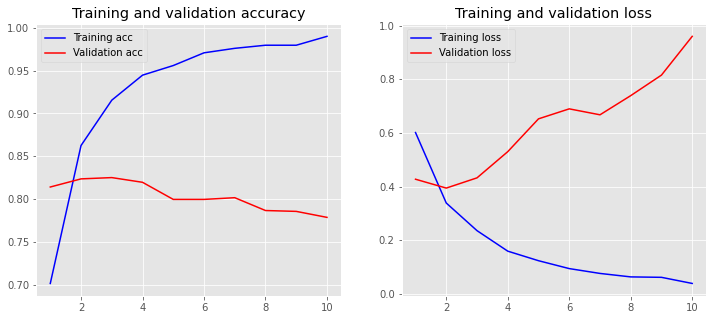

In [36]:
plot_history(h_1)

In [37]:

### Second Model with dropout
m_2 = Sequential()
m_2.add(Embedding(input_dim = 18866, output_dim = 64, input_length = 2048))
m_2.add(SpatialDropout1D(0.2))
m_2.add(LSTM(units = 64, recurrent_dropout = 0.5))
m_2.add(Dropout(0.2))
m_2.add(Dense(units = 1, activation = 'sigmoid'))
m_2.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ['accuracy'])
m_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2048, 64)          1207424   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 2048, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,240,513
Trainable params: 1,240,513
Non-trainable params: 0
_________________________________________________________________


In [38]:
h_2 = m_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)

Epoch 1/10
63/63 [==============================] - 106s 1s/step - loss: 0.6723 - accuracy: 0.5896 - val_loss: 0.5181 - val_accuracy: 0.7725
Epoch 2/10
63/63 [==============================] - 85s 1s/step - loss: 0.4123 - accuracy: 0.8236 - val_loss: 0.3859 - val_accuracy: 0.8300
Epoch 3/10
63/63 [==============================] - 86s 1s/step - loss: 0.2479 - accuracy: 0.9068 - val_loss: 0.4033 - val_accuracy: 0.8340
Epoch 4/10
63/63 [==============================] - 84s 1s/step - loss: 0.1727 - accuracy: 0.9413 - val_loss: 0.5069 - val_accuracy: 0.8270
Epoch 5/10
63/63 [==============================] - 84s 1s/step - loss: 0.1204 - accuracy: 0.9608 - val_loss: 0.5073 - val_accuracy: 0.8000
Epoch 6/10
63/63 [==============================] - 86s 1s/step - loss: 0.0904 - accuracy: 0.9739 - val_loss: 0.6550 - val_accuracy: 0.8030
Epoch 7/10
63/63 [==============================] - 105s 2s/step - loss: 0.0703 - accuracy: 0.9811 - val_loss: 0.7489 - val_accuracy: 0.7995
Epoch 8/10
63/63 [

In [39]:
loss, accuracy = m_2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = m_2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9934
Testing Accuracy:  0.7930


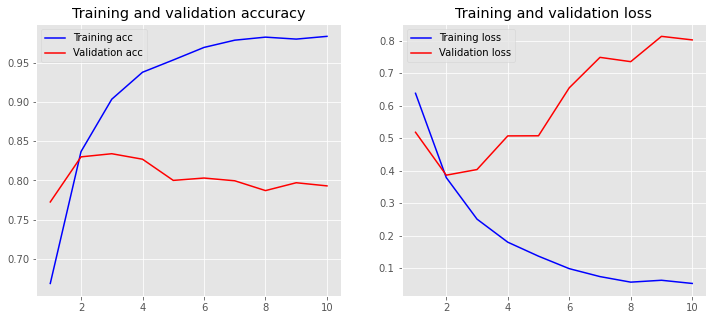

In [40]:
plot_history(h_2)

In [41]:
### Third Model - less complex model higher dropout index

m_3 = Sequential()
m_3.add(Embedding(input_dim = 18866, output_dim = 32, input_length = 2048))
m_3.add(SpatialDropout1D(0.5))
m_3.add(LSTM(units = 32, recurrent_dropout = 0.5))
m_3.add(Dropout(0.5))
m_3.add(Dense(units = 1, activation = 'sigmoid'))
m_3.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ['accuracy'])
m_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2048, 32)          603712    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 2048, 32)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 612,065
Trainable params: 612,065
Non-trainable params: 0
_________________________________________________________________


In [42]:
# split 80% train and 20% test data
X_train, X_test, y_train, y_test = train_test_split(data, y_label, test_size=0.2, random_state=42)

In [43]:
h_3 = m_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)

Epoch 1/10
63/63 [==============================] - 71s 1s/step - loss: 0.6898 - accuracy: 0.5356 - val_loss: 0.6159 - val_accuracy: 0.7290
Epoch 2/10
63/63 [==============================] - 54s 855ms/step - loss: 0.5386 - accuracy: 0.7740 - val_loss: 0.4152 - val_accuracy: 0.8285
Epoch 3/10
63/63 [==============================] - 53s 835ms/step - loss: 0.3755 - accuracy: 0.8495 - val_loss: 0.3888 - val_accuracy: 0.8330
Epoch 4/10
63/63 [==============================] - 57s 902ms/step - loss: 0.2915 - accuracy: 0.8938 - val_loss: 0.3915 - val_accuracy: 0.8315
Epoch 5/10
63/63 [==============================] - 57s 912ms/step - loss: 0.2376 - accuracy: 0.9172 - val_loss: 0.3956 - val_accuracy: 0.8270
Epoch 6/10
63/63 [==============================] - 55s 873ms/step - loss: 0.2012 - accuracy: 0.9303 - val_loss: 0.4613 - val_accuracy: 0.8280
Epoch 7/10
63/63 [==============================] - 53s 835ms/step - loss: 0.1689 - accuracy: 0.9420 - val_loss: 0.4534 - val_accuracy: 0.8200
Ep

In [44]:
loss, accuracy = m_3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = m_3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9834
Testing Accuracy:  0.8120


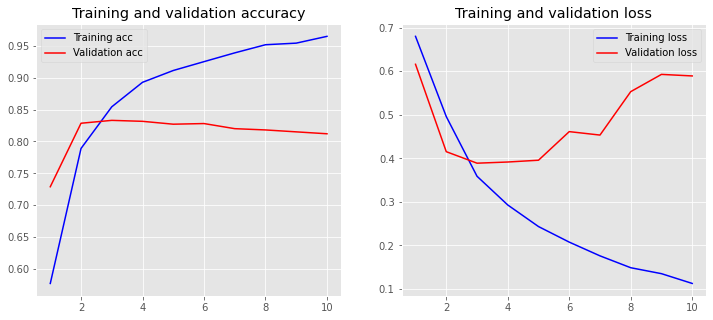

In [45]:
plot_history(h_3)

In [46]:
### fourth Model

m_4 = Sequential()
m_4.add(Embedding(input_dim = 18866, output_dim = 16, input_length = 2048))
m_4.add(SpatialDropout1D(0.5))
m_4.add(LSTM(units = 16, recurrent_dropout = 0.5))
m_4.add(Dropout(0.5))
m_4.add(Dense(units = 1, activation = 'sigmoid'))
m_4.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ['accuracy'])
m_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2048, 16)          301856    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 2048, 16)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 303,985
Trainable params: 303,985
Non-trainable params: 0
_________________________________________________________________


In [47]:
# split 80% train and 20% test data
X_train, X_test, y_train, y_test = train_test_split(data, y_label, test_size=0.2, random_state=42)

In [48]:
h_4 = m_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)

Epoch 1/10
63/63 [==============================] - 50s 721ms/step - loss: 0.6923 - accuracy: 0.5180 - val_loss: 0.6867 - val_accuracy: 0.6360
Epoch 2/10
63/63 [==============================] - 45s 713ms/step - loss: 0.6670 - accuracy: 0.6327 - val_loss: 0.5306 - val_accuracy: 0.7630
Epoch 3/10
63/63 [==============================] - 46s 732ms/step - loss: 0.4901 - accuracy: 0.8001 - val_loss: 0.4085 - val_accuracy: 0.8175
Epoch 4/10
63/63 [==============================] - 44s 699ms/step - loss: 0.3537 - accuracy: 0.8686 - val_loss: 0.3870 - val_accuracy: 0.8295
Epoch 5/10
63/63 [==============================] - 44s 700ms/step - loss: 0.3158 - accuracy: 0.8855 - val_loss: 0.3992 - val_accuracy: 0.8280
Epoch 6/10
63/63 [==============================] - 44s 697ms/step - loss: 0.2698 - accuracy: 0.9116 - val_loss: 0.4137 - val_accuracy: 0.8245
Epoch 7/10
63/63 [==============================] - 44s 706ms/step - loss: 0.2521 - accuracy: 0.9113 - val_loss: 0.4520 - val_accuracy: 0.8240

In [49]:
loss, accuracy = m_4.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = m_4.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9697
Testing Accuracy:  0.8195


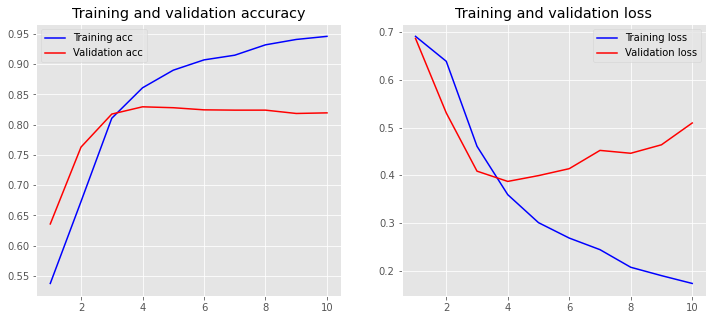

In [50]:
plot_history(h_4)

In [51]:
# fifth model - simple RNN

m_5 = Sequential()
m_5.add(Embedding(input_dim = 18866, output_dim = 32, input_length = 2048))
m_5.add(SpatialDropout1D(0.5))
m_5.add(SimpleRNN(units = 32, activation = 'relu'))
m_5.add(Dropout(0.5))
m_5.add(Dense(units = 1, activation = 'sigmoid'))
m_5.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ['accuracy'])
m_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 2048, 32)          603712    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 2048, 32)          0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 605,825
Trainable params: 605,825
Non-trainable params: 0
_________________________________________________________________


In [52]:
# split 80% train and 20% test data
X_train, X_test, y_train, y_test = train_test_split(data, y_label, test_size=0.2, random_state=42)

In [53]:
h_5 = m_5.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)

Epoch 1/10
63/63 [==============================] - 21s 273ms/step - loss: 0.6934 - accuracy: 0.4968 - val_loss: 0.6895 - val_accuracy: 0.5625
Epoch 2/10
63/63 [==============================] - 20s 316ms/step - loss: 0.6863 - accuracy: 0.5624 - val_loss: 0.6739 - val_accuracy: 0.6335
Epoch 3/10
63/63 [==============================] - 18s 283ms/step - loss: 0.6287 - accuracy: 0.6798 - val_loss: 0.4861 - val_accuracy: 0.7840
Epoch 4/10
63/63 [==============================] - 16s 256ms/step - loss: 0.4386 - accuracy: 0.8184 - val_loss: 0.4004 - val_accuracy: 0.8180
Epoch 5/10
63/63 [==============================] - 16s 261ms/step - loss: 0.3344 - accuracy: 0.8745 - val_loss: 0.4029 - val_accuracy: 0.8190
Epoch 6/10
63/63 [==============================] - 16s 258ms/step - loss: 0.2820 - accuracy: 0.8990 - val_loss: 0.4124 - val_accuracy: 0.8235
Epoch 7/10
63/63 [==============================] - 16s 258ms/step - loss: 0.2071 - accuracy: 0.9268 - val_loss: 0.4580 - val_accuracy: 0.8150

In [54]:
loss, accuracy = m_5.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = m_5.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9781
Testing Accuracy:  0.8155


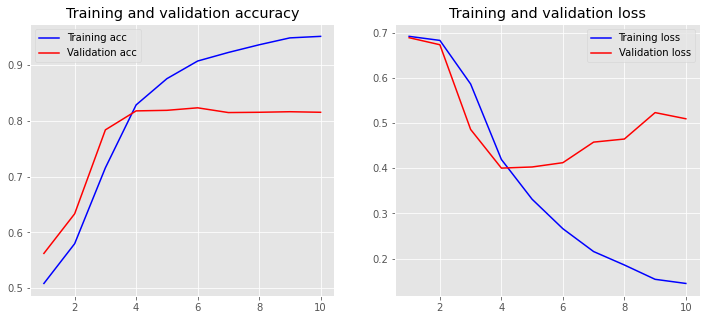

In [55]:
plot_history(h_5)

### Best LSTM

In [56]:
## best lstm model with epoch 5
m_ls = Sequential()
m_ls.add(Embedding(input_dim = 18866, output_dim = 16, input_length = 2048))
m_ls.add(SpatialDropout1D(0.5))
m_ls.add(LSTM(units = 16, recurrent_dropout = 0.5))
m_ls.add(Dropout(0.5))
m_ls.add(Dense(units = 1, activation = 'sigmoid'))
m_ls.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ['accuracy'])
m_ls.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 2048, 16)          301856    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 2048, 16)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 303,985
Trainable params: 303,985
Non-trainable params: 0
_________________________________________________________________


In [57]:
# split 80% train and 20% test data
X_train, X_test, y_train, y_test = train_test_split(data, y_label, test_size=0.2, random_state=42)

In [58]:
h_ls = m_ls.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

Epoch 1/5
63/63 [==============================] - 53s 767ms/step - loss: 0.6916 - accuracy: 0.5420 - val_loss: 0.6670 - val_accuracy: 0.7535
Epoch 2/5
63/63 [==============================] - 45s 708ms/step - loss: 0.6182 - accuracy: 0.7268 - val_loss: 0.4492 - val_accuracy: 0.8205
Epoch 3/5
63/63 [==============================] - 45s 709ms/step - loss: 0.4230 - accuracy: 0.8377 - val_loss: 0.3925 - val_accuracy: 0.8240
Epoch 4/5
63/63 [==============================] - 45s 717ms/step - loss: 0.3435 - accuracy: 0.8755 - val_loss: 0.3876 - val_accuracy: 0.8260
Epoch 5/5
63/63 [==============================] - 45s 718ms/step - loss: 0.3144 - accuracy: 0.8874 - val_loss: 0.4063 - val_accuracy: 0.8305


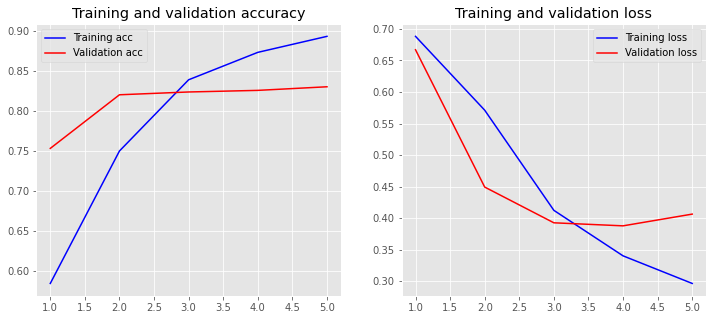

In [59]:
plot_history(h_ls)


In [60]:
loss, accuracy = m_ls.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = m_ls.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9261
Testing Accuracy:  0.8305


In [61]:
ls_pred = (m_ls.predict(X_test) > 0.5).astype("int32")

In [62]:
ls_report = classification_report(y_test, ls_pred)
print('ls_result: \n', ls_report)

ls_result: 
               precision    recall  f1-score   support

           0       0.83      0.83      0.83      1012
           1       0.83      0.83      0.83       988

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



In [63]:
ls_train = (m_ls.predict(X_train) > 0.5).astype("int32")

In [64]:
ls_report_train = classification_report(y_train, ls_train)
print('ls_result: \n', ls_report_train)

ls_result: 
               precision    recall  f1-score   support

           0       0.93      0.92      0.93      3988
           1       0.92      0.93      0.93      4012

    accuracy                           0.93      8000
   macro avg       0.93      0.93      0.93      8000
weighted avg       0.93      0.93      0.93      8000



### Best simpleRNN

In [65]:
# fifth model - simple RNN

m_sr = Sequential()
m_sr.add(Embedding(input_dim = 18866, output_dim = 32, input_length = 2048))
m_sr.add(SpatialDropout1D(0.5))
m_sr.add(SimpleRNN(units = 32, activation = 'relu'))
m_sr.add(Dropout(0.5))
m_sr.add(Dense(units = 1, activation = 'sigmoid'))
m_sr.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ['accuracy'])
m_sr.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 2048, 32)          603712    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 2048, 32)          0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 605,825
Trainable params: 605,825
Non-trainable params: 0
_________________________________________________________________


In [66]:
# split 80% train and 20% test data
X_train, X_test, y_train, y_test = train_test_split(data, y_label, test_size=0.2, random_state=42)

In [67]:
h_sr = m_sr.fit(X_train, y_train.reshape(8000,1), validation_data=(X_test, y_test.reshape(2000,1)), epochs=4, batch_size=128)

Epoch 1/4
63/63 [==============================] - 20s 268ms/step - loss: 0.6936 - accuracy: 0.4999 - val_loss: 0.6883 - val_accuracy: 0.5705
Epoch 2/4
63/63 [==============================] - 16s 259ms/step - loss: 0.6783 - accuracy: 0.5909 - val_loss: 0.5859 - val_accuracy: 0.7590
Epoch 3/4
63/63 [==============================] - 16s 260ms/step - loss: 0.5524 - accuracy: 0.7554 - val_loss: 0.4341 - val_accuracy: 0.8120
Epoch 4/4
63/63 [==============================] - 16s 260ms/step - loss: 0.3973 - accuracy: 0.8397 - val_loss: 0.4064 - val_accuracy: 0.8185


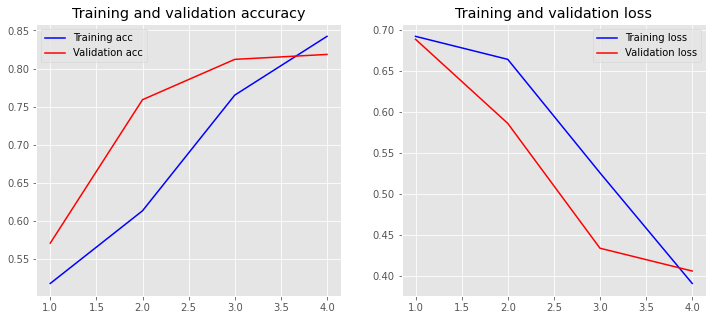

In [68]:
plot_history(h_sr)

In [69]:
loss, accuracy = m_sr.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = m_sr.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9036
Testing Accuracy:  0.8185


In [70]:
sr_pred = (m_sr.predict(X_test) > 0.5).astype("int32")

In [71]:
sr_report = classification_report(y_test, sr_pred)
print('ls_result: \n', sr_report)

ls_result: 
               precision    recall  f1-score   support

           0       0.82      0.83      0.82      1012
           1       0.82      0.81      0.81       988

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



In [72]:
sr_train = (m_sr.predict(X_train) > 0.5).astype("int32")

In [73]:
sr_report_train = classification_report(y_train, sr_train)
print('ls_result_train: \n', sr_report_train)

ls_result_train: 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      3988
           1       0.90      0.91      0.90      4012

    accuracy                           0.90      8000
   macro avg       0.90      0.90      0.90      8000
weighted avg       0.90      0.90      0.90      8000

